# Lecture 5.1: Learning Better Pt.1

This lecture, we are going to use feature scaling and polynomial features to improve the accuracy of a linear regression model.

**Learning goals:**

- scale a feature matrix using standardization
- inverse transform scaled features to visualize the dataset in the original units
- calculate polynomial features
- use scaled polynomial features in a linear regression model

## 1. Introduction

Covid-19 has been a test to our productivity and will power. 📱 In an effort to get our procrastination under control, we have decided to record data everytime we use instagram: the number of minutes we originally _planned_ to quickly check our dms, vs the _actual_ number of minutes we spent on that funny meme page.

Our goal is to _predict_ the actual amount of time we will spend online in order to better organize our day. 📅 This is therefore a _regression_ task with:
- one feature, the number of planned instagram minutes
- a numerical label, the number of actual minutes spent on instagram

## 2. Feature Scaling

Let's load the dataset from csv into a `DataFrame`:

In [1]:
import pandas as pd

df = pd.read_csv('instagram_planning.csv')
df.head()

/Users/amine/.local/share/virtualenvs/practical-data-scientist-umj5maBJ-python/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,planned_minutes,actual_minutes
0,2.617826,3.230395
1,3.559634,3.931186
2,4.903828,7.404192
3,7.075610,9.230352
4,7.243637,7.204204


This dataset only has two columns, so let's visualize it:

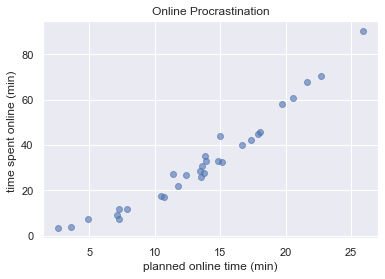

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df['planned_minutes'], df['actual_minutes'], alpha=0.6)

ax.set_xlabel('planned online time (min)')
ax.set_ylabel('time spent online (min) ')
ax.set_title('Online Procrastination');

So this is where all our free time is going... The time spent online is considerably larger than the planned online time for each example.

Notice how the x-axis ranges from 0 to 25 ? It seems that our feature has not been scaled. We can check with the `DataFrame`'s summary statistics:

In [3]:
df.describe()

,planned_minutes,actual_minutes
count,30.000000,30.000000
mean,13.489957,32.485449
std,5.671145,21.314851
min,2.617826,3.230395
25%,10.526172,17.046192
50%,13.677764,29.482019
75%,17.201545,43.459096
max,25.890354,90.495966


Our feature, `planned_minutes`, is not _standardized_. Its mean is far from 0, and its standard deviation is greater than one. We have learned in the slides that feature scaling is almost always a good idea, so let's standardize this column.

We'll use our beloved sklearn for this, and as always, its methods expect a feature _matrix_ , so let's [`.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html?highlight=reshape#numpy.ndarray.reshape) our single feature column into a $(30 \times 1)$ matrix.

In [4]:
X = df['planned_minutes'].values.reshape(-1, 1)
y = df['actual_minutes'].values

We are now able to `.fit()` our `StandardScaler` class:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

This might look weird: why is sklearn using the same `.fit()` api as learning _models_ , when this is just a simple equation to scale a dataset? 

Well if you recall from the slides, standardization updates each feature $x_{i}$ as follows:

$$ \textbf{x}_{i} := \frac{\textbf{x}_{i} - mean(\textbf{x}_{i})}{std(\textbf{x}_{i})}$$

Observe how we need to calculate the _mean_ and _standard deviation_ of the feature across all the examples, in order to be able to standardize each value. This _interface_ is similar to how linear or logistic regression were trained: we passed the entire dataset as function argument. This is why sklearn chooses to reuse the name `.fit()` here, because it is consistent with the rest of its api where a class needs to be fed the dataset, `.fit(X, y)`, to operate. i.e `.fit()` is used when we have to adjust a class' behaviour to a dataset.

Now that we have fit our standardizer to our feature, we can investigate the results. As explained above, the only two parameters that needed fitting here are the _mean_ and the _standard deviation_ of each feature. We can fetch these values as such:

In [6]:
scaler.mean_

array([13.48995696])

In [7]:
scaler.scale_

array([5.57582486])

Therefore we now know that our trained `scaler` instance will standardize `planned_minutes` with the following transformation:

$$ \textbf{x}_{i} := \frac{\textbf{x}_{i} - 13.49}{5.58}$$

And "transformation" is the correct term here: this is the name sklearn chose for the main method of its  `preprocessing` classes. We are indeed not _predicting_ anything here, but _updating_ the dataset. Without further a do:

In [8]:
X_scaled = scaler.transform(X)

# show the first 5 rows
X_scaled[:5]

array([[-1.9498695 ],
       [-1.78096026],
       [-1.53988495],
       [-1.15038537],
       [-1.12025036]])

The `.transform()` method returned our updated feature matrix, `X_scaled`. We can verify the standardization by visualizing the regression task once again:

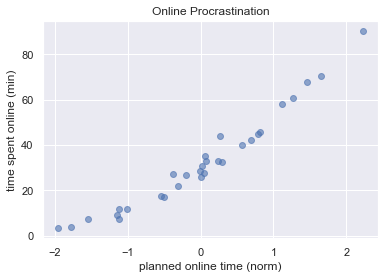

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_scaled, y, alpha=0.6)

ax.set_xlabel('planned online time (norm)')
ax.set_ylabel('time spent online (min)')
ax.set_title('Online Procrastination');

The `planned_minutes` feature, on the x-axis, has indeed been re-scaled.

Notice that the y-axis hasn't changed, because it contains the _labels_ , and that feature scaling only applies to ... features!

🧠 Can you think of why it is not useful to scale labels?

Feature scaling is cool, and helps learning algorithms... but we have lost the _interpretability_ of our visualization. What does 1 normalized unit of planned online time correspond to? 🤨 This graph is much harder to read! 

It is therefore important to know how to do _inverse_ the scaling applied to our features. That way, we can use the standardized values for learning, and change back the original units when reporting or visualizing the data.

sklearn allows us to do this with `.inverse_transform()`. Remember how we previously `.fit()` our `StandardScaler`? It now remembers the mean and standard deviation of each feature, so it can reverse the standardization equation and recover the original values:

In [10]:
X_descaled = scaler.inverse_transform(X_scaled)

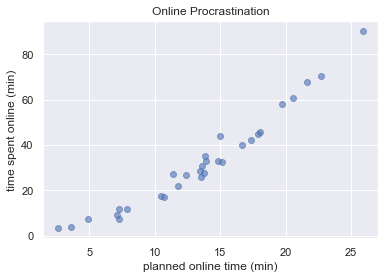

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_descaled, y, alpha=0.6)

ax.set_xlabel('planned online time (min)')
ax.set_ylabel('time spent online (min)')
ax.set_title('Online Procrastination');

The unit of minutes of our `planned_minutes` was recovered!

Granted, in this case, we still had access to the original `X` feature matrix, so re-calculating `X_descaled` wasn't super useful... 😅but knowing how to reverse preprocessing transformations in sklearn can be handy!

And on the topic of usefulness: we learned in the slides that feature scaling was useful to _balance_ the features. This helped with the training of learning algorithms. However our dataset has only one feature... so it doesn't really need to be balanced against anything. Feature scaling in this example isn't particularly useful. However, it has given us an opportunity to discover the sklearn _preprocessing_ api. Which we will need for the next section...


## 3. Polynomial Regression

### 3.1 Training

We wish to predict the actual amount of time we will spend online from the original `planned_minutes`. This is a regression task that can be solved using _linear regression_ :

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)

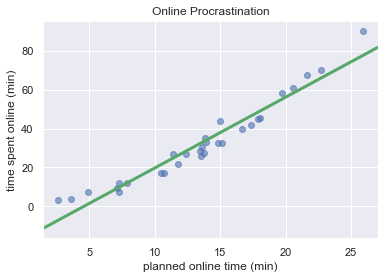

In [13]:
import numpy as np 

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the examples
ax.scatter(X, y, alpha=0.6)

# plot the hypothesis
theta = np.append(reg.intercept_, reg.coef_)
xmin, xmax = ax.get_xlim()
x_line = np.linspace(xmin, xmax, 30)
y_line = theta[0] + theta[1] * x_line
ax.plot(x_line, y_line, c='g', linewidth=3)

# formatting
ax.set_xlim(xmin, xmax)
ax.set_xlabel('planned online time (min)')
ax.set_ylabel('time spent online (min)')
ax.set_title('Online Procrastination');

Our linear regression model correctly models the upwards trend in `actual_minutes`. However, it doesn't capture the slightly _parabolic_ nature of the data. i.e our model doesn't look very _accurate_.

In order to fit this non-linear relationship between `actual_minutes` and `planned_minutes`, we must use a non-linear model. We have learned how to use _polynomial features_ to "boost" our linear regression hypothesis.

sklearn offers polynomial regression under the form of another _preprocessor_ , [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). This uses same api as the `StandardScaler` from the [previous section](#2.-Feature-Scaling). It is in line with the `.fit()` and `.transform()` interface, since our polynomial features have to be calculated from the entire dataset, and are then added to the feature matrix.

Let's apply polynomial features of degree 2 to our feature matrix `X`:

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
poly = poly.fit(X)
X_poly = poly.transform(X)

# show the first 5 rows
X_poly[:5]

array([[ 2.61782613,  6.85301362],
       [ 3.55963446, 12.67099748],
       [ 4.90382818, 24.04753078],
       [ 7.07560963, 50.06425164],
       [ 7.24363716, 52.47027937]])

Our feature matrix, `X_poly`, now has two columns. The first column is our `planned_minutes`, the second is `planned_minutes` _squared_. We can verify this manually using the first row:

$$ 2.618^{2} = 6.853 $$

Which means that we now have polynomial features! This also means we have more than one feature. And as outlined in the [previous section](#2.-Feature-Scaling), features are best learned when they are _balanced_. We should therefore feature scale our new feature matrix `X_poly`.

ℹ️ It is important to apply feature scaling _after_ polymial features are calculated. Scaled features will _not_ stay standardized when raised to the power of $n$. This is because exponents will change the standard deviation of a variable.

We create a new `StandardScaler` instance since the previous one was already fitted to the original feature matrix `X`:

In [15]:
scaler = StandardScaler()
scaler = scaler.fit(X_poly)
X_poly_scaled = scaler.transform(X_poly)

# show the first 5 rows
X_poly_scaled[:5]

array([[-1.9498695 , -1.31590293],
       [-1.78096026, -1.27877724],
       [-1.53988495, -1.20618136],
       [-1.15038537, -1.04016359],
       [-1.12025036, -1.02481026]])

It looks like our features values were indeed updated, but we can check that the standardization worked by looking at the mean and standard deviation of our columns:

In [ ]:
x1 = X_poly_scaled[:, 0]
x2 = X_poly_scaled[:, 1]

print(f'feature 1 mean: {x1.mean()}, standard deviation: {x1.std()}')
print(f'feature 2 mean: {x2.mean()}, standard deviation: {x2.std()}')

We are now ready for polynomial regression. We simply have to use our balanced polynomial features in a linear regression model:

In [16]:
reg = LinearRegression().fit(X_poly_scaled, y)

theta = np.append(reg.intercept_, reg.coef_)
theta

array([32.48544896,  3.93802553, 16.93537999])

We have learned 3 model parameters $\theta$, as expected for two features. Since we know that the second feature is the square of the first feature, we can write our hypothesis as such:

$$ h_{\theta}(x) = 32.49 + 3.94 x + 16.94 x^{2} $$

with $x$ our `planned_minutes` feature.

### 3.2 Prediction

We can now use this trained regression model to predict the time we might spend online based on how long we were planning to browse instagram.

Let's figure out how long we will spend online if we plan to browse instagram for $15$ minutes. We can make a feature matrix by sticking $15$ and $15^{2}$ in a NumPy `ndarray`:

In [17]:
# create feature matrix 
planned_minutes = 15
X_predict = np.array([15, 15**2]).reshape(1, 2)

# predict
y_predict = reg.predict(X_predict)
y_predict


array([3902.01633062])

So if we plan to spend 15 minutes on instagram, we end up wasting... 3902 minutes?? 😰 That doesn't sound right. Indeed, we have forgotten to _scale our features_. Recall that we trained the regression model with scaled features to help its optimization process. Except now it's model parameters, $\theta$, are going to be expecting _scaled_ data! Therefore we must always remember to apply the same transformations to the features we use for prediction, as the ones we used for training. This is super important, and is one of the most common bugs in machine learning 🙃

Since we still have our fitted `scaler` and `poly` preprocessing instances, we can use both of them to apply all the feature transformations we need in one go. That way we don't have to manually calculate polynomial features, or apply the standardization equation, and most importantly we don't forget anything 😅.

ℹ️ sklearn offers a convenient [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) api to stack preprocessors and models into one object. That way, it's even harder to forget some feature transformations!

Let's try our prediction again, this time using our previously fitted preprocessors. As always, the sklearn api expects features _matrices_ , so we reshape the feature `ndarray` to a $(1 \times 1)$ matrix from the very start:

In [18]:
# create feature matrix
planned_minutes = 15
X_predict = np.array(15).reshape(1, 1)

# apply feature transformations
X_predict_poly = poly.transform(X_predict)
X_predict_poly_scaled = scaler.transform(X_predict_poly)

# predict
y_predict = reg.predict(X_predict_poly_scaled)
y_predict

array([34.84132839])

35 minutes spent online for 15 planned seems a more reasonable guess 😌.

### 3.3 Visualization

To get a better overview of this model's predictions, we wish to visualize the non-linear hypothesis. Previously, we have used the values of $\theta$ directly to calculate the predictions and plot them as a line:

    x_line = np.linspace(-3, 3, 30)
    y_line = theta[0] + theta[1] * x_line
    ax.plot(x_line, y_line)
   
This creates an array of 30 points for our feature `x`, calculates the predictions directly using the hypothesis equation, then plots resulting line. 

However, we are now that we are dealing with feature scaling and high degree polynomials. So instead of manually calculating all these transformations and hypotheses on the features for predictions, we would like to leverage our fitted `reg` instance to predict the values of y. For this, we can use our preprocessors and the familiar `.predict()` api:

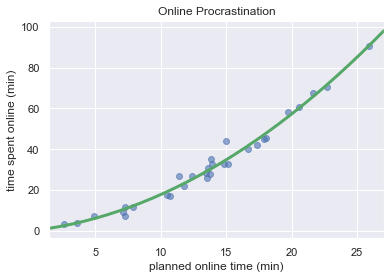

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the examples
ax.scatter(X, y, alpha=0.6)

# create feature matrix
xmin, xmax = ax.get_xlim()
x_line = np.linspace(xmin, xmax, 30).reshape(-1, 1)

# apply feature transformations
x_line_poly = poly.transform(x_line)
x_line_poly_scaled = scaler.transform(x_line_poly)

# predict
y_line = reg.predict(x_line_poly_scaled)

# plot the hypothesis
ax.plot(x_line, y_line, c='g', linewidth=3)

# formatting
ax.set_xlim(xmin, xmax)
ax.set_xlabel('planned online time (min)')
ax.set_ylabel('time spent online (min)')
ax.set_title('Online Procrastination');

This is a better fit for our data, and we can expect predictions with this polynomial regression model to be more accurate than the linear regression model. 🏹

🧠🧠 Note that we are not plotting the preprocessed features `X_poly_scaled` and `x_line_poly_scaled` in this graph. Instead we use `X` and `x_line`. Why is that?

Since adding polynomial features of degree 2 helped our regression model, perhaps adding degree 4 polynomials would be even better...

💪💪 Add polynomial features of degree 4 to our dataset. Scale the resulting features with standardization. Then use the final feature matrix to train a polynomial regression model. The function to plot the hypothesis is provided and already called. To pass the unit test, please use the following naming convention:
- `poly`: polynomial features preprocessor
- `scaler`: standardization preprocessor
- `reg`: regression model

Pro-tip: start with the clean original feature matrix `X` or the sklearn preprocessors will get confused by the transformations of the previous cells

Success! 🎉


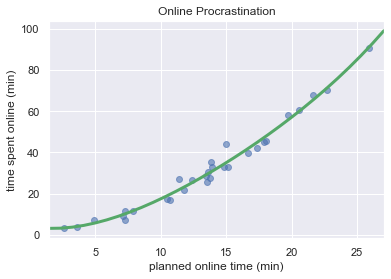

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(4, include_bias=False)
poly = poly.fit(X)
X_poly = poly.transform(X)
#X_poly[:5]

scaler = StandardScaler()
scaler = scaler.fit(X_poly)
X_poly_scaled = scaler.transform(X_poly)

reg = LinearRegression().fit(X_poly_scaled, y)

def plot_polynomial_regression(X, y, reg, poly, scaler):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot the examples
    ax.scatter(X, y, alpha=0.6)

    # create feature matrix
    xmin, xmax = ax.get_xlim()
    x_line = np.linspace(xmin, xmax, 30).reshape(-1, 1)

    # apply feature transformations
    x_line_poly = poly.transform(x_line)
    x_line_poly_scaled = scaler.transform(x_line_poly)

    # predict
    y_line = reg.predict(x_line_poly_scaled)

    # plot the hypothesis
    ax.plot(x_line, y_line, c='g', linewidth=3)

    # formatting
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('planned online time (min)')
    ax.set_ylabel('time spent online (min)')
    ax.set_title('Online Procrastination');
    
import math

def test_predict():
    x_predict = np.array(25).reshape(1, 1)
    x_predict_poly = poly.transform(x_predict)
    x_predict_poly_scaled = scaler.transform(x_predict_poly)
    y_predict = reg.predict(x_predict_poly_scaled)
    assert math.isclose(y_predict, 85.01418, rel_tol=1e-4), "The model isn't predicting the expected value"
    print('Success! 🎉')

test_predict()
plot_polynomial_regression(X, y, reg, poly, scaler)

In [21]:
X_poly[:5]

array([[2.61782613e+00, 6.85301362e+00, 1.79399981e+01, 4.69637957e+01],
       [3.55963446e+00, 1.26709975e+01, 4.51041193e+01, 1.60554177e+02],
       [4.90382818e+00, 2.40475308e+01, 1.17924959e+02, 5.78283736e+02],
       [7.07560963e+00, 5.00642516e+01, 3.54235101e+02, 2.50642929e+03],
       [7.24363716e+00, 5.24702794e+01, 3.80075666e+02, 2.75313022e+03]])

In [23]:
scaler.mean_

array([1.34899570e+01, 2.13068762e+02, 3.72016867e+03, 6.99564640e+04])

In [25]:
scaler.scale_

array([5.57582486e+00, 1.56710455e+02, 3.91894872e+03, 9.67005162e+04])

In [26]:
X_poly_scaled[:5]

array([[-1.9498695 , -1.31590293, -0.94469944, -0.72294857],
       [-1.78096026, -1.27877724, -0.93776796, -0.72177391],
       [-1.53988495, -1.20618136, -0.91918623, -0.71745408],
       [-1.15038537, -1.04016359, -0.85888686, -0.69751473],
       [-1.12025036, -1.02481026, -0.85229311, -0.69496355]])

🧠🧠 Does the degree 4 polynomial regression model look more accurate than the degree 2? Why do you think that is?

## 4. Summary

Today, we have discovered two techniques to improve our learning algorithms, **feature scaling** and **polynomial features**. We highlighted that machine learning algorithms "prefer" **balanced** features, and that **standardization** is a method to make their mean and standard deviation uniform. We then understood the limitations of **linear models**, and learned how to calculate **polynomial features** to learn more complex hypotheses. Finally, we used these techniques to learn the **non-linear relationship** between the time we plan to spend online vs how long we end up procrastinating.

# Resources

## Core Resources

- [sklearn - the importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)  
A visual example of the effect of feature scaling on PCA
- [all about feature scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)  
Comprehensive breakdown of different feature scaling methods
- [sklearn - polynomial features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)  
sklearn official documentation on `PolynomialFeatures`
- [sklearn - preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)  
All sklearn preprocessors in one place

## Additional Resources

- [standardization vs normalization](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html)
- [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
- [Quantitative comparison of different feature scaling methods on model accuracy](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)